#   Trabalho Computacional 2. Perceptron Multicamada no problema MNIST

> Nome: *Gabriel Martins Silveira de Oliveira*  
> Matrícula: 190042656


## Sumário

Neste projeto, será realizada a implementação de um modelo Perceptron Multicamadas (MLP), 
evoluindo a partir do conceito do Perceptron original.  
Todas as implementações utilizarão o conjunto de dados 
(dataset) MNIST, fornecido pela biblioteca PyTorch.

Serão exploradas as seguintes configurações e variações do modelo:

1.  **MLP com uma Camada Oculta e Otimizador SGD:**
    *   Implementação de um Perceptron Multicamadas com uma camada oculta contendo 128 neurônios.
    *   Utilização da função de ativação Sigmoide (logística) na camada oculta.
    *   Utilização da função de ativação Softmax na camada de saída (adequada para classificação multiclasse como o MNIST).
    *   Otimização realizada por meio da Descida de Gradiente Estocástico (SGD).

2.  **Otimizador Adam:**
    *   Substituição do otimizador SGD pelo Adam, que ajusta adaptativamente a taxa de aprendizado para cada parâmetro do modelo, visando uma convergência potencialmente mais eficiente.

3.  **Função de Ativação ReLU:**
    *   Substituição da função de ativação Sigmoide pela ReLU (Rectified Linear Unit) na(s) camada(s) oculta(s), analisando seu impacto no desempenho e na mitigação do problema de desaparecimento do gradiente.

4.  **Exploração de Arquiteturas Maiores:**
    *   Avaliação do impacto do aumento da capacidade do modelo através de:
        *   Um MLP com uma única camada oculta contendo 256 neurônios.
        *   Um MLP com duas camadas ocultas, cada uma contendo 128 neurônios.

## Entendendo O DataSet



In [140]:
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Estarei salvando tudo em [`./data`](./data/)

In [141]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=4, # Tentei Melhorar a performance
    pin_memory=True
)

test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
test_loader = DataLoader(
    test_dataset, batch_size=1000, shuffle=False, num_workers=4, pin_memory=True
)

Apos carregar o data set podemos analizar suas dimenções.

In [142]:
print(f"Classes: {test_dataset.classes.__len__()}",*test_dataset.classes, sep="\n")

Classes: 10
0 - zero
1 - one
2 - two
3 - three
4 - four
5 - five
6 - six
7 - seven
8 - eight
9 - nine


Podemos ver que estamos classificando 10 diferentes classes.  
Aparentemente estamos classificando números. 

In [143]:
examples = enumerate(train_loader)
batch_idx, (x, y) = next(examples)

print(f"{x.shape=}", f"{y.shape=}", sep="\n")

x.shape=torch.Size([64, 1, 28, 28])
y.shape=torch.Size([64])


Temos um tensor de `batch_size` (64) exemplos, 1 canal e dois canais de dimenção 28.

In [144]:
x[0, 0, :2, :2]

tensor([[-0.4242, -0.4242],
        [-0.4242, -0.4242]])

Ambos canais de 28 por 28 mostram a intensidade da luz

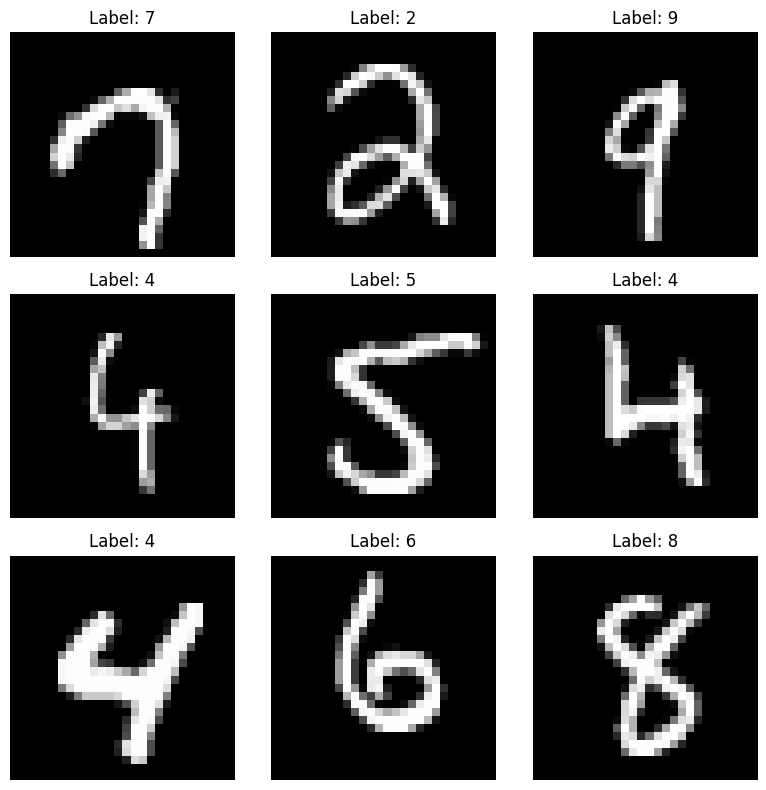

In [145]:
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
for ax, i in zip(ax.flatten(), range(9)):
    ax.imshow(x[i][0], cmap="gray")
    ax.set_title(f"Label: {y[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

Confirmamos que realmente estamos classificando números.

## Funções a serem utilizadas

Vamos definir algumas funções que utilizaremos ao longo do codigo

In [146]:
import torch
import numpy as np
from torch.optim import Optimizer, SGD
from torch import Tensor, device, no_grad
from torch.nn import Module, Sequential, Flatten, Linear, Sigmoid, CrossEntropyLoss

### Modelo Base

Uma vez que estaremos lidando com diferentes casos sera conveniente 
definir um modelo base em que alteramos funções basicas e assim podemos analizar modelos diferentes.

In [147]:
class BaseModel(Module):
    def __init__(self):
        super().__init__()
        self.train_data = train_loader
        self.eval_data = test_loader
        self.device = device("cuda" if torch.cuda.is_available() else "cpu")

    def get_optimizer(self) -> Optimizer:
        raise NotImplementedError

    def get_loss_fn(self) -> Module:
        raise NotImplementedError

### Função de treinamento

Treinamento do modelo dentro de uma época

In [ ]:
def train(
    model: BaseModel,
    train_losses: list[float],
):
    data_loader = model.train_data
    loss_fn = model.get_loss_fn()
    optmizer = model.get_optimizer()
    device = model.device
    model.train()
    current_loss = 0
    for data, target in data_loader:
        # Pode comentar, gosto de type hint
        data: Tensor = data
        target: Tensor = target

        data, target = data.to(device=device), target.to(
            device=device
        )  # Quero rodar na GPU

        optmizer.zero_grad(set_to_none=True)
        logits = model(data)
        loss: Tensor = loss_fn(logits, target)
        loss.backward()
        optmizer.step()
        current_loss += loss.item()

    avg_loss = current_loss / len(data_loader)
    train_losses.append(avg_loss)

### Função de validação

In [149]:
def val(
    model: BaseModel,
    eval_losses: list[float],
) -> tuple[np.ndarray, np.ndarray]:
    data_loader = model.eval_data
    loss_fn = model.get_loss_fn()
    device = model.device
    model.eval()
    with no_grad():
        all_preds = []
        all_targets = []
        current_loss = 0
        for data, target in data_loader:
            # Pode comentar, gosto de type hint
            data: Tensor = data
            target: Tensor = target

            data, target = data.to(device=device), target.to(
                device=device
            )  # Quero rodar na GPU

            logits: Tensor = model(data)
            loss: Tensor = loss_fn(logits, target)
            current_loss += loss.item()

            pred = logits.argmax(dim=1) # Predição sera o maior das 10 classes
            
            all_preds.append(pred.cpu().numpy())
            all_targets.append(target.cpu().numpy())

        avg_loss = current_loss / len(data_loader)
        eval_losses.append(avg_loss)

        return np.concatenate(all_targets), np.concatenate(all_preds)

### Função de acuracia

A função de acuracia sera definida pela quantidade de cassos classificados corretamente
sobre o total de casos. 

In [150]:
def get_acc(y: np.ndarray, pred: np.ndarray, accuracies: list):
    """Pega a Acuracia.
    Necessário alimentar com todo o vetor de treinamento.

    Args:
        y (Tensor): Valores verdadeiros
        pred (Tensor): Predição
    """

    correct_predictions = np.sum(y == pred)
    total_predictions = len(y)
    accuracy = correct_predictions / total_predictions
    accuracies.append(accuracy)

### Função de Final 

Aqui Vamos fazer um analize de cada modelo

In [151]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def get_info(model: BaseModel, num_epoches: int):
    train_losses = []
    eval_losses = []
    accuracies = []
    
    # For storing the final true and predicted values for confusion matrix
    final_targets = None
    final_preds = None

    print(f"Training on device: {model.device}")

    # --- Matplotlib Setup for Live Plotting ---
    plt.ion()  # Turn on interactive mode
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6)) # (width, height)

    # Initial setup for Loss Plot (ax1)
    ax1.set_title("Perda Média por Época")
    ax1.set_xlabel("Época")
    ax1.set_ylabel("Perda")
    ax1.set_xlim(0.5, num_epoches + 0.5) # Adjusted for better epoch 1 visibility
    # Initial y_lim, will be adjusted dynamically
    min_loss_display = 0
    max_loss_display = 2.5 # A common starting point for CE loss
    ax1.set_ylim(min_loss_display, max_loss_display)


    # Initial setup for Accuracy Plot (ax2)
    ax2.set_title("Acurácia de Validação por Época")
    ax2.set_xlabel("Época")
    ax2.set_ylabel("Acurácia")
    ax2.set_xlim(0.5, num_epoches + 0.5) # Adjusted
    ax2.set_ylim(0, 1.05) # Accuracy is between 0 and 1

    # Line objects for updating data later (optional, but good for efficiency)
    # If not using this, cla() and replotting is fine as in your example
    line_train_loss, = ax1.plot([], [], 'r-o', label="Perda Treinamento")
    line_val_loss, = ax1.plot([], [], 'b-o', label="Perda Validação")
    line_accuracy, = ax2.plot([], [], 'g-o', label="Acurácia Validação")
    
    ax1.legend(loc='upper right')
    ax2.legend(loc='lower right')
    # --- End Matplotlib Setup ---

    for epoche in range(1, num_epoches + 1):
        epoch_list = list(range(1, epoche + 1)) # x-axis for plots
        print(f"--- Época: {epoche}/{num_epoches} ---")

        train(model=model, train_losses=train_losses)
        # Store the latest validation results for confusion matrix
        final_targets, final_preds = val(model=model, eval_losses=eval_losses)
        get_acc(y=final_targets, pred=final_preds, accuracies=accuracies)

        print(
            f"  Train loss: {train_losses[-1]:.4f}",
            f"  Val loss: {eval_losses[-1]:.4f}",
            f"  Val Accuracy: {accuracies[-1]:.4f}",
            sep="\n",
        )

        # --- Live Plot Update ---
        # Update Loss Plot (ax1)
        line_train_loss.set_data(epoch_list, train_losses)
        line_val_loss.set_data(epoch_list, eval_losses)
        
        # Dynamically adjust Y-axis for loss plot
        if train_losses or eval_losses: # Check if lists are not empty
            current_max_loss = 0
            if train_losses: current_max_loss = max(current_max_loss, max(train_losses))
            if eval_losses: current_max_loss = max(current_max_loss, max(eval_losses))
            max_loss_display = max(max_loss_display, current_max_loss * 1.1) # Keep expanding if needed
            
            current_min_loss = float('inf')
            if train_losses: current_min_loss = min(current_min_loss, min(train_losses))
            if eval_losses: current_min_loss = min(current_min_loss, min(eval_losses))
            min_loss_display = min(min_loss_display, current_min_loss * 0.9) if current_min_loss > 0 else 0

            ax1.set_ylim(min_loss_display, max_loss_display)


        # Update Accuracy Plot (ax2)
        line_accuracy.set_data(epoch_list, accuracies)
        
        # Redraw the figure
        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.pause(0.1)  # Pause allows the plot to update
        # --- End Live Plot Update ---

    print("\nTraining finished.")

    # --- Plot Finalization ---
    plt.ioff() # Turn off interactive mode
    ax1.legend() # Ensure legends are there on the final static plot
    ax2.legend()
    plt.show() # Display the final plot and keep it open
    # --- End Plot Finalization ---

    # --- Confusion Matrix ---
    if final_targets is not None and final_preds is not None:
        print("\n--- Confusion Matrix (sobre o último conjunto de validação) ---")
        cm = confusion_matrix(final_targets, final_preds)
        cm_df = pd.DataFrame(
            cm,
            index=[f"True_{i}" for i in range(10)], # Assuming 10 classes for MNIST
            columns=[f"Pred_{i}" for i in range(10)]
        )
        print(cm_df)
    else:
        print("\nNão foi possível gerar a matriz de confusão (sem dados de validação).")
    # --- End Confusion Matrix ---



In [152]:
from IPython.display import display, clear_output 

def get_info(model: BaseModel, num_epoches: int):
    train_losses = []
    eval_losses = []
    accuracies = []
    
    final_targets = None
    final_preds = None

    # Initial print statement (will appear once above the updating plot)
    print(f"Starting training on device: {model.device} for {num_epoches} epochs.")

    # --- Matplotlib Setup ---
    # No plt.ion() needed for this Jupyter approach
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6)) # (width, height)

    # Setup for Loss Plot (ax1)
    ax1.set_title("Perda Média por Época")
    ax1.set_xlabel("Época")
    ax1.set_ylabel("Perda")
    ax1.set_xlim(0.5, num_epoches + 0.5)
    # Dynamic Y-limits for loss, initialize them
    overall_min_loss = float('inf')
    overall_max_loss = float('-inf')
    ax1.set_ylim(0, 2.5) # Initial sensible default
    line_train_loss, = ax1.plot([], [], 'r-o', label="Perda Treinamento")
    line_val_loss, = ax1.plot([], [], 'b-o', label="Perda Validação")
    ax1.legend(loc='upper right')

    # Setup for Accuracy Plot (ax2)
    ax2.set_title("Acurácia de Validação por Época")
    ax2.set_xlabel("Época")
    ax2.set_ylabel("Acurácia")
    ax2.set_xlim(0.5, num_epoches + 0.5)
    ax2.set_ylim(-0.05, 1.05) # Fixed Y-limits for accuracy (0-1 range with padding)
    line_accuracy, = ax2.plot([], [], 'g-o', label="Acurácia Validação")
    ax2.legend(loc='lower right')
    
    plt.tight_layout() # Adjust layout to prevent overlap of titles/labels

    for epoche in range(1, num_epoches + 1):
        epoch_list = list(range(1, epoche + 1)) # x-axis for plots

        # --- Training and Validation ---
        train(model=model, train_losses=train_losses)
        final_targets, final_preds = val(model=model, eval_losses=eval_losses)
        get_acc(y=final_targets, pred=final_preds, accuracies=accuracies)

        # --- Update Plot Data ---
        line_train_loss.set_data(epoch_list, train_losses)
        line_val_loss.set_data(epoch_list, eval_losses)
        
        # Dynamically adjust Y-axis for loss plot (ax1)
        if train_losses:
            overall_min_loss = min(overall_min_loss, min(train_losses))
            overall_max_loss = max(overall_max_loss, max(train_losses))
        if eval_losses:
            overall_min_loss = min(overall_min_loss, min(eval_losses))
            overall_max_loss = max(overall_max_loss, max(eval_losses))

        # Set Y Lim for loss plot, ensuring valid range
        display_min_y_loss = max(0, overall_min_loss * 0.9) if overall_min_loss != float('inf') else 0
        display_max_y_loss = overall_max_loss * 1.1 if overall_max_loss != float('-inf') else ax1.get_ylim()[1]
        if display_min_y_loss >= display_max_y_loss : display_max_y_loss = display_min_y_loss + 0.1 # Ensure max > min
        ax1.set_ylim(display_min_y_loss, display_max_y_loss)

        # Update Accuracy Plot (ax2) - Y limits are fixed, just update data
        line_accuracy.set_data(epoch_list, accuracies)
        
        # --- Jupyter Live Update ---
        clear_output(wait=True) # Clear the previous output of the cell
        
        # Print current epoch's stats
        print(f"--- Época: {epoche}/{num_epoches} ---")
        print(
            f"  Train loss: {train_losses[-1]:.4f}",
            f"  Val loss: {eval_losses[-1]:.4f}",
            f"  Val Accuracy: {accuracies[-1]:.4f}",
            sep="\n",
        )
        
        display(fig) # Display the updated figure in the cell
        # --- End Jupyter Live Update ---

    # The last plot and text will remain in the cell output after the loop.
    # No plt.ioff() or final plt.show() is strictly needed for this pattern.
    # However, closing the figure object is good practice if you might re-run
    # this function multiple times to avoid accumulating figure objects in memory.
    # If you want the plot to *disappear* after this cell runs, then call plt.close(fig) here.
    # If you want it to *stay*, don't call plt.close(fig) immediately.

    print("\nTraining finished.") # This will print below the final plot

    # --- Confusion Matrix ---
    if final_targets is not None and final_preds is not None:
        print("\n--- Confusion Matrix (sobre o último conjunto de validação) ---")
        cm = confusion_matrix(final_targets, final_preds)
        # Assuming 10 classes for MNIST (0-9)
        class_names = [str(i) for i in range(10)] 
        cm_df = pd.DataFrame(
            cm,
            index=[f"True_{name}" for name in class_names],
            columns=[f"Pred_{name}" for name in class_names]
        )
        print(cm_df)
    else:
        print("\nNão foi possível gerar a matriz de confusão (sem dados de validação).")
    
    # Optional: Close the figure if you are done with it and don't want it to linger
    # if you plan to generate more plots later or re-run.
    # If you want the plot to stay visible in the notebook output, you might omit this,
    # or rely on Jupyter's management / %matplotlib magic behavior.
    # For this clear_output/display pattern, the plot will persist in the output cell
    # even if closed here, because display() creates a representation.
    # plt.close(fig) 

In [ ]:
from torch.utils.data import DataLoader, Dataset 

# MNIST normalization constants (define these globally or pass them around)
MNIST_MEAN = (0.1307,)
MNIST_STD = (0.3081,)

# --- Helper function to unnormalize an image tensor (from your code) ---
def unnormalize_image(tensor_image, mean, std):
    """Unnormalizes a tensor image."""
    unnormalized_tensor = tensor_image.clone() # Clone to avoid modifying original
    # Iterate over channels. For MNIST, C=1, so this loop runs once.
    # t will be the [H,W] tensor, m and s will be the scalar mean/std.
    for t, m, s in zip(unnormalized_tensor, mean, std):
        t.mul_(s).add_(m)
    return unnormalized_tensor

# --- Function to update live metrics plot ---
def update_live_metrics_plot(
    ax1: plt.Axes,
    ax2: plt.Axes,
    line_train_loss: plt.Line2D,
    line_val_loss: plt.Line2D,
    line_accuracy: plt.Line2D,
    epoch_list: list[int],
    train_losses: list[float],
    eval_losses: list[float],
    accuracies: list[float],
    current_overall_min_loss: float,
    current_overall_max_loss: float
):
    """Updates the data and y-limits for the live metrics plot."""
    line_train_loss.set_data(epoch_list, train_losses)
    line_val_loss.set_data(epoch_list, eval_losses)
    line_accuracy.set_data(epoch_list, accuracies)

    # Dynamically adjust Y-axis for loss plot (ax1)
    display_min_y_loss = max(0, current_overall_min_loss * 0.9) if current_overall_min_loss != float('inf') else 0
    display_max_y_loss = current_overall_max_loss * 1.1 if current_overall_max_loss != float('-inf') else ax1.get_ylim()[1]
    
    if display_min_y_loss >= display_max_y_loss: # Ensure max > min
        display_max_y_loss = display_min_y_loss + 0.1 
    ax1.set_ylim(display_min_y_loss, display_max_y_loss)
    # ax2 y-limits (accuracy) are typically fixed, set during initialization.

# --- Function to plot misclassified examples ---
def plot_misclassified_examples(
    targets: np.ndarray,
    preds: np.ndarray,
    dataset: Dataset, # The torchvision.datasets.MNIST object
    num_to_show: int = 9,
    img_mean: tuple = MNIST_MEAN, # Use global MNIST_MEAN/STD by default
    img_std: tuple = MNIST_STD
):
    """Plots a grid of misclassified examples from the given dataset."""
    misclassified_indices = np.where(targets != preds)[0]
    actual_num_to_show = min(len(misclassified_indices), num_to_show)

    if actual_num_to_show > 0:
        print(f"\n--- {actual_num_to_show} Exemplos de Classificações Incorretas ---")
        
        cols = 3
        rows = (actual_num_to_show + cols - 1) // cols # Calculate rows needed
        
        fig_errors, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 3))
        # Handle the case where subplots returns a single Axes object (not an array)
        if actual_num_to_show == 1:
            axes = np.array([axes]) # Make it an array of one Axes
        axes = axes.flatten() # Now flatten works for single or multiple axes

        for i in range(actual_num_to_show):
            idx_in_dataset = misclassified_indices[i]
            
            # Get the original image tensor and true label from the dataset
            img_tensor, true_label_from_ds = dataset[idx_in_dataset]
            
            # Unnormalize the image for display (ensure tensor is on CPU)
            img_unnorm = unnormalize_image(img_tensor.cpu(), img_mean, img_std)

            pred_label = preds[idx_in_dataset]
            true_label = targets[idx_in_dataset] # Should match true_label_from_ds

            ax = axes[i]
            # Squeeze to remove channel dim for grayscale, convert to numpy
            ax.imshow(img_unnorm.squeeze().numpy(), cmap='gray')
            ax.set_title(f"True: {true_label}\nPred: {pred_label}")
            ax.axis('off')
        
        # Hide any unused subplots if num_to_show < rows*cols
        for j in range(actual_num_to_show, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show() # Show this new figure for errors
    else:
        print("\nParabéns! Nenhuma classificação incorreta encontrada no último conjunto de validação!")

# --- Main Info Gathering Function (Refactored) ---
def get_info(model: BaseModel, num_epoches: int): # Removed val_dataset_for_plotting
    train_losses = []
    eval_losses = []
    accuracies = []
    
    # Store targets/preds from the *last* validation run for final analysis
    final_targets_epoch = None
    final_preds_epoch = None

    print(f"Starting training on device: {model.device} for {num_epoches} epochs.")

    # --- Matplotlib Setup for Live Metrics ---
    fig_metrics, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.set_title("Perda Média por Época")
    ax1.set_xlabel("Época")
    ax1.set_ylabel("Perda")
    ax1.set_xlim(0.5, num_epoches + 0.5)
    # Trackers for dynamic Y-axis scaling of loss plot
    overall_min_loss_tracker, overall_max_loss_tracker = float('inf'), float('-inf')
    ax1.set_ylim(0, 2.5) # Initial sensible default for loss
    line_train_loss, = ax1.plot([], [], 'r-o', label="Perda Treinamento")
    line_val_loss, = ax1.plot([], [], 'b-o', label="Perda Validação")
    ax1.legend(loc='upper right')

    ax2.set_title("Acurácia de Validação por Época")
    ax2.set_xlabel("Época")
    ax2.set_ylabel("Acurácia")
    ax2.set_xlim(0.5, num_epoches + 0.5)
    ax2.set_ylim(-0.05, 1.05) # Fixed Y-limits for accuracy
    line_accuracy, = ax2.plot([], [], 'g-o', label="Acurácia Validação")
    ax2.legend(loc='lower right')
    
    plt.tight_layout() # Adjust layout for the metrics plot

    for epoche in range(1, num_epoches + 1):
        epoch_list = list(range(1, epoche + 1)) # X-axis values for plots
        
        # --- Training and Validation ---
        train(model=model, train_losses=train_losses)
        # `val` returns targets and predictions for the current epoch
        final_targets_epoch, final_preds_epoch = val(model=model, eval_losses=eval_losses)
        get_acc(y=final_targets_epoch, pred=final_preds_epoch, accuracies=accuracies)

        # --- Update Overall Loss Trackers ---
        if train_losses: # Check if list is not empty
            overall_min_loss_tracker = min(overall_min_loss_tracker, min(train_losses))
            overall_max_loss_tracker = max(overall_max_loss_tracker, max(train_losses))
        if eval_losses: # Check if list is not empty
            overall_min_loss_tracker = min(overall_min_loss_tracker, min(eval_losses))
            overall_max_loss_tracker = max(overall_max_loss_tracker, max(eval_losses))

        # --- Update Live Plot ---
        update_live_metrics_plot(
            ax1, ax2, line_train_loss, line_val_loss, line_accuracy,
            epoch_list, train_losses, eval_losses, accuracies,
            overall_min_loss_tracker, overall_max_loss_tracker
        )
        
        # --- Jupyter Live Update: Clear previous output, print new stats, display updated figure ---
        clear_output(wait=True)
        print(f"--- Época: {epoche}/{num_epoches} ---")
        print(
            f"  Train loss: {train_losses[-1]:.4f}",
            f"  Val loss: {eval_losses[-1]:.4f}",
            f"  Val Accuracy: {accuracies[-1]:.4f}",
            sep="\n",
        )
        display(fig_metrics) # Display the updated metrics plot

    print("\nTraining finished.")
    # The metrics plot (fig_metrics) will remain in the cell output.
    # If you need to close it explicitly (e.g., if calling get_info in a loop), use:
    # plt.close(fig_metrics) 

    # --- Post-Training Analysis (Confusion Matrix & Misclassified Examples) ---
    if final_targets_epoch is not None and final_preds_epoch is not None:
        # Confusion Matrix
        print("\n--- Confusion Matrix (sobre o último conjunto de validação) ---")
        cm = confusion_matrix(final_targets_epoch, final_preds_epoch)
        class_names = [str(i) for i in range(10)] # Assuming 10 classes for MNIST
        cm_df = pd.DataFrame(
            cm,
            index=[f"True_{n}" for n in class_names],
            columns=[f"Pred_{n}" for n in class_names]
        )
        print(cm_df)

        # Plot Misclassified Images
        # Access the dataset from the model's DataLoader
        if hasattr(model.eval_data, 'dataset') and isinstance(model.eval_data.dataset, Dataset):
            validation_dataset = model.eval_data.dataset
            plot_misclassified_examples(
                targets=final_targets_epoch,
                preds=final_preds_epoch,
                dataset=validation_dataset, # Pass the actual dataset object
                num_to_show=9
                # img_mean and img_std will use defaults MNIST_MEAN, MNIST_STD
            )
        else:
            print("\nAlerta: Não foi possível obter o `dataset` do `model.eval_data`.")
            print("Certifique-se que `model.eval_data.dataset` é um objeto `torch.utils.data.Dataset` válido.")
    else:
        print("\nNão foi possível gerar a matriz de confusão ou mostrar erros (sem dados de validação finais).")

In [154]:
def get_info(model: BaseModel, num_epoches: int):

    train_losses = []

    for epoche in range(1, num_epoches + 1):
        print(f"--- Época: {epoche}/{num_epoches} ---")

        train(model=model, train_losses=train_losses)

In [ ]:

class Modelo1(BaseModel):
    def __init__(self):
        super().__init__()
        self.model = Sequential(
            Flatten(),
            Linear(28 * 28, 128),
            Sigmoid(),
            Linear(128, 10),
        )
        self.to(self.device)
        
    def forward(self, x):
        return self.model(x)
    
    def get_optimizer(self) -> Optimizer:
        return SGD(self.parameters(), lr=0.1, momentum=0.9)
    
    def get_loss_fn(self) -> Module:
        return CrossEntropyLoss()

In [156]:
model = Modelo1()

get_info(model=model, num_epoches=5)


--- Época: 1/5 ---
--- Época: 2/5 ---
--- Época: 3/5 ---
--- Época: 4/5 ---
--- Época: 5/5 ---
